In [ ]:
a = [1, 2, 3, 5 ,8]
print(a[:2])

In [ ]:
def a():
    for i in range(100):
        yield 1
itr = a()
print(next(itr))

In [ ]:
next(itr)

In [ ]:
next(itr)

In [ ]:
itr.__new__()

In [ ]:
from torchvision.io import read_image

In [ ]:
import torch
import torch.nn as nn

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()

        # 1x1 convolution branch
        self.branch1x1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)

        # 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )

        # 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )

        # Max pooling branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )

    def forward(self, x):
        # Forward pass through each branch and concatenate the outputs
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)

        # Concatenate along the channel dimension
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        op = torch.cat(outputs, 1)
        print(op.shape)
        return op
    

# Example usage:
in_channels = 3  # Input channels (e.g., for an RGB image)
out_1x1 = 64
red_3x3 = 128
out_3x3 = 192
red_5x5 = 32
out_5x5 = 96
out_pool = 64

inception_module = InceptionModule(in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool)

# Example input tensor
input_tensor = torch.randn(1, in_channels, 224, 224)

# Forward pass through the Inception module
output_tensor = inception_module(input_tensor)

print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool, fc_units):
        super(InceptionModule, self).__init__()

        # 1x1 convolution branch
        self.branch1x1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)

        # 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )

        # 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )

        # Max pooling branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )

        # Fully connected layer
        self.fc = nn.Linear(out_1x1 + out_3x3 + out_5x5 + out_pool, fc_units)

    def forward(self, x):
        # Forward pass through each branch
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)

        # Concatenate along the channel dimension
        concat_features = torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], 1)
        print(concat_features.shape)
        # Flatten the features before passing through the fully connected layer
        flat_features = concat_features.view(concat_features.size(0), -1)
        flat_features1 = torch.flatten(concat_features, 1)
        flat_features1 = flat_features[np.newaxis, :]
        print(flat_features.shape)
        print(flat_features1.shape)

        # Fully connected layer
        fc_output = self.fc(flat_features)

        return fc_output

# Example usage:
in_channels = 3  # Input channels (e.g., for an RGB image)
out_1x1 = 64
red_3x3 = 128
out_3x3 = 192
red_5x5 = 32
out_5x5 = 96
out_pool = 64
fc_units = 256  # Number of units in the fully connected layer

inception_module = InceptionModule(in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool, fc_units)

# Example input tensor
input_tensor = torch.randn(1, in_channels, 224, 224)

# Forward pass through the Inception module
output_tensor = inception_module(input_tensor)

print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)


In [ ]:
import torch
tensor = torch.randn(2, 3, 4, 2)
print(tensor.size())
print(tensor.view(3, -1))
print(tensor.view(3, -1).shape)
print(torch.flatten(tensor, 2))
print(torch.flatten(tensor, 2).shape)

In [ ]:
from torchvision.io import read_image, ImageReadMode
import numpy as np
a = read_image("M:/2023_Predator_Alternative_Wallpaper_A New Beginning_3840x2160.png", ImageReadMode.RGB)
print(a.shape)
a = a.permute(1, 2, 0)

print(a.shape)
a = np.array(a)
import cv2
a = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)
a = cv2.resize(a, (400, 400))
cv2.imshow("img", a)
cv2.waitKey(1000)
cv2.destroyAllWindows()

from PIL import Image
a = Image.open("M:/2023_Predator_Alternative_Wallpaper_A New Beginning_3840x2160.png")
a = a.convert("RGB")
display(a)
print(a.size)



a = cv2.imread("M:/2023_Predator_Alternative_Wallpaper_A New Beginning_3840x2160.png")
print(a.shape)
print(a.size)

In [ ]:
import torch
import numpy as np
import cv2
a = torch.randn(100, 200, 3)
# print(a)
a = a.permute(2, 0, 1)
print(a.shape)
print(a)
a = a.permute(1, 2, 0)
a = np.array(a)
cv2.imshow("img", a)
cv2.waitKey(1000)
cv2.destroyAllWindows()

In [ ]:
a = read_image("M:/Datasets/FaceRecognition/labels-5/100016/0.png")
a.shape

In [ ]:
print(a.shape)
print(a)

In [ ]:
import pandas as pd
data = pd.read_csv("W:\Projects\FaceRecognition\Models\Data\Dataset.csv")
bs = 12
b = 8
position = bs*(b-1)
data.iloc[position:position+bs, :]

In [ ]:
import pandas as pd
data = pd.read_csv("W:\Projects\FaceRecognition\Models\Data\Dataset.csv")
bs = 12
b = 8
position = bs*(b-1)
data = data.iloc[position:position+bs, :]
data[0]

In [ ]:
import pandas as pd
data = pd.read_csv("W:\Projects\FaceRecognition\Models\Data\Dataset.csv")
bs = 12
b = 8
position = bs*(b-1)
data.iloc[position:position+bs, :]
data.head()

In [ ]:
import pandas as pd
data = pd.read_csv("W:\Projects\FaceRecognition\Models\Data\Dataset.csv")
bs = 12
b = 8
position = bs*(b-1)
data = data.iloc[position:position+bs, :]
data.head()

In [ ]:
data.iloc[0]

In [ ]:
data.iloc[0]['Anchor']

In [ ]:
import pandas as pd
data = pd.read_csv("W:\Projects\FaceRecognition\Models\Data\Dataset.csv")
bs = 12
b = 8
position = bs*(b-1)
data = data.iloc[position:position+bs, :]
data.head()
for i in range(len(data)):
    print(i)
for i in data:
    print(i)

In [ ]:
for i in range(len(data)):
    images = []
    for j, _ in enumerate(data):
        print(data.iloc[i, j])
    print("\n")

In [ ]:
data.head()

In [ ]:
import torch
from torchvision.io import read_image, ImageReadMode
import numpy as np
a = [1, 250]
a = read_image("M:/Datasets/FaceRecognition/labels-5/100000/1.png", ImageReadMode.RGB)
# a = a.transpose()
a = torch.transpose(a, 0, 1)
a = torch.transpose(a, 1, 2)
print(a.shape)
# break
a = np.array(a)
import cv2
cv2.imshow("img", a)
cv2.waitKey(0)
cv2.destroyAllWindows()
# print(cv2.imread("M:/Datasets/FaceRecognition/labels-5/100000/1.png").shape)
# print(torch.divide(a[0][0][0], 255, ))

# a = torch.divide(torch.asarray(a, dtype = torch.float64), 255)
# a = a/255.0
# print(a.dtype)
torch.set_printoptions(profile = "full")
print(a.shape)
print(a)
# print(torch.asarray(a, dtype=torch.float64)/255)

In [ ]:
import torch
print(torch.clamp(torch.as_tensor([5, 0]), 1))

In [4]:
path = "Data/Dataset.csv"
import pandas as pd
data = pd.read_csv(path)
import numpy as np
data.head(5)

,Anchor,Positive,Negative
0,W:/Projects/FaceRecognition/Models/Datasets/Fa...,W:/Projects/FaceRecognition/Models/Datasets/Fa...,W:/Projects/FaceRecognition/Models/Datasets/Fa...
1,W:/Projects/FaceRecognition/Models/Datasets/Fa...,W:/Projects/FaceRecognition/Models/Datasets/Fa...,W:/Projects/FaceRecognition/Models/Datasets/Fa...
2,W:/Projects/FaceRecognition/Models/Datasets/Fa...,W:/Projects/FaceRecognition/Models/Datasets/Fa...,W:/Projects/FaceRecognition/Models/Datasets/Fa...
3,W:/Projects/FaceRecognition/Models/Datasets/Fa...,W:/Projects/FaceRecognition/Models/Datasets/Fa...,W:/Projects/FaceRecognition/Models/Datasets/Fa...
4,W:/Projects/FaceRecognition/Models/Datasets/Fa...,W:/Projects/FaceRecognition/Models/Datasets/Fa...,W:/Projects/FaceRecognition/Models/Datasets/Fa...


In [5]:
data = data.values
print(data.shape[0])
print(len(data))
print(data)

77000
77000
[['W:/Projects/FaceRecognition/Models/Datasets/FaceRecognition/labels-5/100000/0.png'
  'W:/Projects/FaceRecognition/Models/Datasets/FaceRecognition/labels-5/100000/5.png'
  'W:/Projects/FaceRecognition/Models/Datasets/FaceRecognition/labels-5/114982/0.png']
 ['W:/Projects/FaceRecognition/Models/Datasets/FaceRecognition/labels-5/100000/0.png'
  'W:/Projects/FaceRecognition/Models/Datasets/FaceRecognition/labels-5/100000/2.png'
  'W:/Projects/FaceRecognition/Models/Datasets/FaceRecognition/labels-5/102712/1.png']
 ['W:/Projects/FaceRecognition/Models/Datasets/FaceRecognition/labels-5/100000/0.png'
  'W:/Projects/FaceRecognition/Models/Datasets/FaceRecognition/labels-5/100000/3.png'
  'W:/Projects/FaceRecognition/Models/Datasets/FaceRecognition/labels-5/122622/5.png']
 ...
 ['W:/Projects/FaceRecognition/Models/Datasets/FaceRecognition/labels-72/1898/0.png'
  'W:/Projects/FaceRecognition/Models/Datasets/FaceRecognition/labels-72/1898/54.png'
  'W:/Projects/FaceRecognition/Mode

In [ ]:
from sklearn.model_selection import train_test_split
a, b = train_test_split(data, test_size=0.2, shuffle=False)
print(a.shape)
print(b.shape)

In [7]:
import torch
import torch.nn.functional as F

# Assuming x and y are tensors representing two sets of points
x = torch.tensor([[1.0, 2.0, 3.0]])
y = torch.tensor([[7.0, 8.0, 9.0]])
z = torch.tensor([[3.0, 1.0, 4.0]])

# Compute Euclidean distance (equivalent to pairwise_distance with p=2)
distance = F.pairwise_distance(x, y, p=1)
print(distance)
distance = F.pairwise_distance(x, y, p=2)
print(distance)
distance = F.pairwise_distance(x, y, p=3)
print(distance)
distance = F.pairwise_distance(x, y, p=4)
print(distance)
distance = F.pairwise_distance(x, y, p=5)
print(distance)
print("\n")
distance = F.pairwise_distance(x, z, p=1)
print(distance)
distance = F.pairwise_distance(x, z, p=2)
print(distance)
distance = F.pairwise_distance(x, z, p=3)
print(distance)
distance = F.pairwise_distance(x, z, p=4)
print(distance)
distance = F.pairwise_distance(x, z, p=5)
print(distance)


tensor([18.0000])
tensor([10.3923])
tensor([8.6535])
tensor([7.8964])
tensor([7.4744])


tensor([4.0000])
tensor([2.4495])
tensor([2.1544])
tensor([2.0598])
tensor([2.0244])


In [11]:
import torch
from torch import nn as nn
from torch import optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler


class Model(nn.Module):
    def __init__(self, in_channels, embedding_size, batch_size, p_dropout, p_linear_dropout):
        super(Model, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size=1, padding=0),
                                   nn.AvgPool2d(kernel_size=2, stride=2))
        

        self.b1 = nn.Conv2d(3, 64, kernel_size=1, padding="same")
        self.b2 = nn.Sequential(nn.Conv2d(in_channels, 92, kernel_size=1, padding="same"),
                                nn.Conv2d(92, 128, kernel_size=3, padding="same"))
        self.b3 = nn.Sequential(nn.Conv2d(in_channels, 24, kernel_size=1, padding="same"),
                                nn.Conv2d(24, 32, kernel_size=5, padding="same"))
        self.b4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, padding=1, stride = 1),
                                nn.Conv2d(in_channels, 32, kernel_size=1, padding="same"))
        

        self.b5 = nn.Conv2d(256, 32, kernel_size=1, padding="same")
        self.b6 = nn.Sequential(nn.Conv2d(256, 128, kernel_size=1, padding="same"),
                                nn.Conv2d(128, 64, kernel_size=3, padding="same"))
        self.b7 = nn.Sequential(nn.Conv2d(256, 24, kernel_size=1, padding="same"),
                                nn.Conv2d(24, 16, kernel_size=5, padding="same"))
        self.b8 = nn.Sequential(nn.MaxPool2d(kernel_size=3, padding=1, stride = 1),
                                nn.Conv2d(256, 16, kernel_size=1, padding="same"))

        self.dropout = nn.Dropout2d(p_dropout)

        self.b5 = nn.Conv2d(256, 32, kernel_size=1, padding="same")
        self.b6 = nn.Sequential(nn.Conv2d(256, 128, kernel_size=1, padding="same"),
                                nn.Conv2d(128, 64, kernel_size=3, padding="same"))
        self.b7 = nn.Sequential(nn.Conv2d(256, 24, kernel_size=1, padding="same"),
                                nn.Conv2d(24, 16, kernel_size=5, padding="same"))
        self.b8 = nn.Sequential(nn.MaxPool2d(kernel_size=3, padding=1, stride = 1),
                                nn.Conv2d(256, 16, kernel_size=1, padding="same"))
        
        self.fc = nn.Sequential(nn.Linear(401408, 512, bias=True),
                                nn.Dropout(p_linear_dropout),
                                nn.Linear(512, embedding_size, bias=True))
        
        self.batch_size = batch_size
        
    def forward(self, x):
        x = self.conv(x)

        xb1 = self.b1(x)
        xb2 = self.b2(x)
        xb3 = self.b3(x)
        xb4 = self.b4(x)
        x = torch.cat([xb1, xb2, xb3, xb4], dim = 1)

        x = self.dropout(x)

        xb5 = self.b5(x)
        xb6 = self.b6(x)
        xb7 = self.b7(x)
        xb8 = self.b8(x)
        x = torch.cat([xb5, xb6, xb7, xb8], dim = 1)

        x = self.dropout(x)

        
        x = x.view(self.batch_size, -1)
        x = self.fc(x)

        return x

In [13]:
import torch

# Assuming your model expects input images with 3 channels and size 256x256
batch_size = 1  # You can adjust the batch size
in_channels = 3
image_size = (112, 112)

# Create a random input tensor
sample_input = torch.rand((batch_size, in_channels, *image_size))

# Instantiate your model
embedding_size = 128  # You can adjust the embedding size
p_dropout = 0.5
p_linear_dropout = 0.3
model = Model(in_channels, embedding_size, batch_size, p_dropout, p_linear_dropout)

# Pass the input through the model
output = model(sample_input)
print(output)
# Print the output shape
print("Output shape:", output.shape)


tensor([[ 0.0239,  0.0732,  0.1490,  0.0123,  0.0208,  0.0492, -0.1234, -0.0815,
          0.1561,  0.0435, -0.0483,  0.0423, -0.0674, -0.0273,  0.0601,  0.1457,
         -0.1493,  0.0574,  0.0187,  0.1827,  0.0406,  0.1396,  0.0131,  0.0534,
         -0.1483,  0.0182, -0.1108, -0.0984, -0.0748,  0.0761, -0.0199, -0.1126,
         -0.1302,  0.1328, -0.1969, -0.0453, -0.0492,  0.0248, -0.1084, -0.1192,
          0.1149,  0.0241, -0.1722,  0.0532,  0.0424, -0.0042, -0.0999,  0.1342,
          0.1198, -0.0740,  0.0639,  0.0794,  0.0367, -0.0343, -0.0472,  0.1189,
         -0.0551,  0.1241,  0.0905, -0.0604,  0.0863, -0.0172,  0.0117, -0.1287,
          0.0582, -0.0742, -0.0392,  0.1068, -0.0021,  0.0420, -0.1933, -0.0401,
          0.1983,  0.0848, -0.0293,  0.2292,  0.1509, -0.1337,  0.0344, -0.2019,
          0.1708, -0.0746,  0.1380, -0.0310,  0.0189,  0.1341, -0.2015, -0.0515,
          0.1205, -0.0339, -0.2414, -0.2466,  0.0597,  0.0040, -0.0242, -0.1615,
          0.0313,  0.0380, -

In [7]:
import torch

# Assuming x and y are tensors representing two sets of points
x = torch.tensor([[1.0, 2.0, 3.0]])
y = torch.tensor([[7.0, 8.0, 9.0]])

# Compute Minkowski distance with p=2 (equivalent to Euclidean distance)
distance = torch.cdist(x, y, p=2)
print(distance)


tensor([[10.3923]])


In [17]:
import torch

# Get the current device
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the current device
print("Current Device:", current_device)

# Create a tensor on the current device
tensor_on_current_device = torch.tensor([1, 2, 3]).to(current_device)

# Alternatively, you can directly use the current device without explicitly creating it
tensor_on_current_device = torch.tensor([1, 2, 3]).to(device=current_device)


Current Device: cuda


Cost after iteration 0: 0.6936251451619984
Cost after iteration 100: 0.687809722077625
Cost after iteration 200: 0.6841938090937976
Cost after iteration 300: 0.6819354593658423
Cost after iteration 400: 0.6805177357333827
Cost after iteration 500: 0.6796230394755856
Cost after iteration 600: 0.6790555190242802
Cost after iteration 700: 0.6786937804134245
Cost after iteration 800: 0.6784621558914391
Cost after iteration 900: 0.6783132124880311
Predictions: [[0.65181593 0.59161964 0.51523502 0.60735181 0.50964031 0.5207633
  0.62791032 0.54888811 0.66498369 0.58999598]]


In [ ]:
data.shape

In [ ]:
# data = data[0:2, :]
print(data.shape)
np.random.shuffle(data)
print(data.shape)
print(data[0:70000].shape)

In [ ]:
import numpy as np

# Assuming 'data' is your NumPy array
data = np.array([[1, 2, 3],
                 [4, 5, 6],
                 [7, 8, 9]])

# Shuffle the array along the first axis (rows)
np.random.shuffle(data)

# Now 'data' is shuffled by rows
print(data)


In [16]:
from tqdm import tqdm
import time
for i in range(3):
    loop = tqdm(range(3), leave=True, total=3)
    for j in loop:
        time.sleep(1)
        loop.set_description(f"[{i+1}/{3}]")
        # loop.set_postfix(batch=batch, loss=loss.item())
    for k in tqdm(range(3), leave=True, total=3):
        time.sleep(1)
    print("\n")


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

In [9]:
for i in range(1, 11):
    print(i)

1
2
3
4
5
6
7
8
9
10


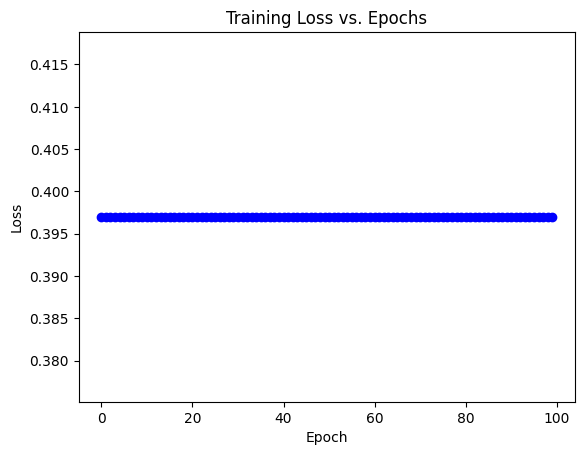

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Define a simple neural network and loss function
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        return self.fc(x)

# Function to train the model and visualize the loss dynamically
def train_and_visualize_live(model, criterion, optimizer, num_epochs=100):
    # Initialize the plot
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss vs. Epochs')
    line, = ax.plot([], [], marker='o', color='b')
    plt.show()

    # Training loop
    for epoch in range(num_epochs):
        # Generate dummy data
        inputs = torch.rand((100, 1))
        targets = 3 * inputs + 2 + 0.1 * torch.randn_like(inputs)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the plot dynamically
        line.set_xdata(range(epoch + 1))
        line.set_ydata([loss.item()] * (epoch + 1))
        ax.relim()
        ax.autoscale_view()

        # Update the plot in the notebook
        clear_output(wait=True)
        display(fig)

        # Pause to visualize
        time.sleep(0.1)

    # Turn off interactive mode after training
    plt.ioff()
    plt.show()

# Instantiate the model, loss function, and optimizer
model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model and visualize the loss dynamically
train_and_visualize_live(model, criterion, optimizer)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2

# Define a simple neural network and loss function
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        return self.fc(x)

# Function to train the model and visualize the loss dynamically
def train_and_visualize(model, criterion, optimizer, num_epochs=100, video_path='loss_video.mp4'):
    # Set up video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(video_path, fourcc, 2.0, (800, 600))

    # Training loop
    for epoch in range(num_epochs):
        # Generate dummy data
        inputs = torch.rand((100, 1))
        targets = 3 * inputs + 2 + 0.1 * torch.randn_like(inputs)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Plot and save frame
        plt.plot(epoch, loss.item(), marker='o', color='b')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss vs. Epochs')
        plt.savefig('temp.png')
        img = cv2.imread('temp.png')
        out.write(img)

    # Release video writer
    out.release()

# Instantiate the model, loss function, and optimizer
model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model and visualize the loss dynamically
train_and_visualize(model, criterion, optimizer)
